# Data exploration

Below is an overview of the various exploratory analyses I carried out in order to determine possible useful features. A lot of the code snippets are obsolete or have since been included in a \*.py file. I keep them here as a reference for myself.

At the bottom is also a log of the results from successive iterations of the model, trained on single users as well as multi-user data sets. 

In [ ]:
! pip install --user requests
! pip install --user Pillow
! pip install --user beautifulsoup4

# Set up modules and preview data

In [1]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features

import json

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S

In [2]:
# Example functions definitions used for testing features.
# In the final version of my analysis, these are all cleaned up and imported from features.py

def not_in_list(x,args,y):
    list = x['caption'].split(' #')
    return not (args in list[1:])

def convertString(x):
    string = str(x)
    if 'k' in string:
        number = float( ''.join(string.split('k')[0].split(',')) ) * 1000
    elif 'm' in string:
        number = float( ''.join(string.split('m')[0].split(',')) ) * 1000000
    else:
        number = float( ''.join(string.split(',')) )
    return number

def extractTimeData(x):
    if not (type(x) is int):
        return 7, 25
    createdtime = datetime.fromtimestamp(int(x))
    hour = createdtime.hour
    weekday = createdtime.weekday()
    #date(2017,9,16).weekday()
    return weekday, hour

In [4]:
# What does the data look like?

print len(posts)
print images.shape
data = pandas.DataFrame(posts)

In [7]:
# Only use posts that were successfully scraped with images.
# Now a function in utils.py

hasImage = []
for i in range(images.shape[0]):
    if (images[i].mean() == 0.):
        hasImage += [False]
    else:
        hasImage += [True]
print len(hasImage)
images2 = []
images2 = images[hasImage]
print images2.shape, images.shape

650
(375, 750, 750, 3) (650, 750, 750, 3)


In [9]:
if False:
    index = 11

    fig = plt.figure(figsize=[15,15])

    ax1 = fig.add_subplot(221)
    ax1.imshow(images2[index]/255.)

    ax2 = fig.add_subplot(222)
    hist,bins = np.histogram(images2[index]/255.,bins=1000)
    ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

    plt.show()

    print data.iloc[index]

In [2]:
foodposts, foodimages = utils.getData('posts_food_1505318769.json',rawimages=True)
print len(foodposts), foodimages.shape
data = pandas.DataFrame(foodposts)

326 (326, 300, 300, 3)


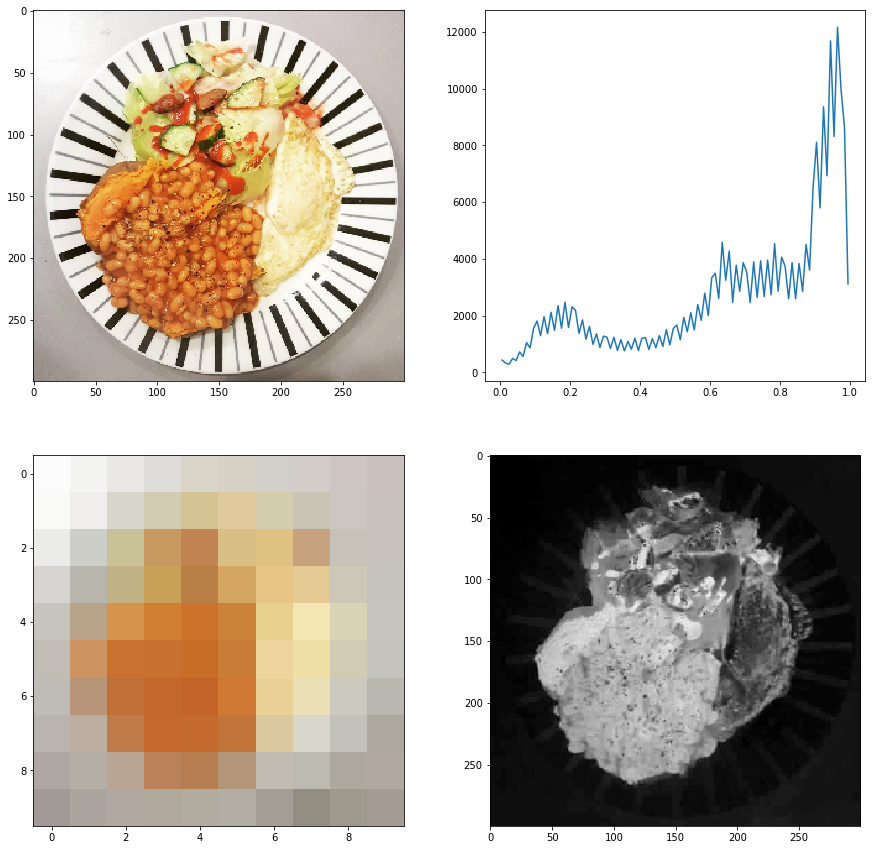

caption      Carbbssss 🙋‍♀️ I'm eating out tonight so this ...
code                                               BY_L581ndZD
comments                                                     2
date                                                1505318753
height                                                    1080
id                                         1603052353213027907
imgurl       https://instagram.fbed1-1.fna.fbcdn.net/t51.28...
likes                                                       24
timestamp                                          1.50535e+09
userid                                                17219868
width                                                     1080
Name: 11, dtype: object


In [5]:
# What do the image features look like?

index = 11

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(221)
ax1.imshow(foodimages[index]/255.)

ax2 = fig.add_subplot(222)
hist,bins = np.histogram(foodimages[index]/255.,bins=100)
ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

ax3 = fig.add_subplot(223)
newimage = np.zeros([10,10,3])
for i in range(3):
    newimage[:,:,i] = imresize(foodimages[index,:,:,i],[10,10])
ax3.imshow(newimage/255.)

ax4 = fig.add_subplot(224)
rgb = foodimages[index]
saturation = features.saturation(rgb,options=['xyz','mean'])
saturation = features.colorfulness(rgb,option='rgb')
ax4.imshow(saturation, cmap='gray')

plt.show()

print data.iloc[index]

# Run analysis for a hashtag, include user info (followers, following, etc)

In [5]:
# Get data

posts, images = utils.getData('posts_cake_1505409284.json',updated=True,rawimages=True)
with open('data/users_cake_1505409284.json','r') as infile:
        users = json.load(infile)
        #'posts_food_1505318769.json'

dfu = pandas.DataFrame(users)
dfp = pandas.DataFrame(posts)

In [6]:
# Extract image features

nbins = 20
satH = np.zeros([len(posts),nbins])
conH = np.zeros([len(posts),nbins])
sat = np.zeros([len(posts)])
contrast = np.zeros([len(posts)])

dims = 5
comp = np.zeros([len(posts),dims**2])

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

MSE: 0.053055
R2S: 0.150689


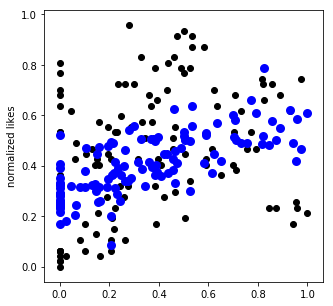

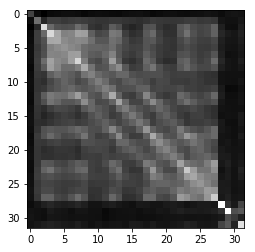

[ 0.00026628  0.00178517  0.00350653  0.00495689  0.00369989  0.0024662
  0.0016325   0.00403867  0.00185776 -0.00025902  0.00111984 -0.00040231
  0.00049438  0.00070729 -0.00035052  0.00276514  0.00246325  0.00097688
  0.00293531  0.00076987  0.00052592  0.00143554  0.00237591  0.00535487
  0.00381712  0.0012428   0.00081845  0.00136658  0.0155885   0.02188758
  0.00480759  0.06494757]


In [7]:
# Extract metadata features

likes = dfp['likes'].apply(lambda x: float(convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1

followers = dfu['followers'].apply(lambda x: float( convertString(x) )).values
following = dfu['following'].apply(lambda x: convertString(x)).values


# Prune and normalize data

keep = (likes < 50) & (likes > 1)
keep = dfp.apply(not_in_list,args=[u'fashion',0],axis=1).values & keep & (followers < 500)

goodposts = dfp.loc[keep]
goodsat = sat[keep]
goodcontrast = conH[keep]
gcomp = comp[keep]

likes = likes[keep]
ntags = ntags[keep]
followers = followers[keep]
following = following[keep]

minsat = np.min(sat)
maxsat = np.max(sat)
mincon = np.min(goodcontrast)
maxcon = np.max(goodcontrast)
minlike = min(likes)
maxlike = max(likes)
#mincomp = min(comp)
#maxcomp = max(comp)
mintags = min(ntags)
maxtags = max(ntags)

goodsat = (goodsat - minsat)/(maxsat-minsat)
goodcontrast = (goodcontrast - mincon)/(maxcon-mincon)
likes = (likes - minlike)/(maxlike - minlike)
#likes = likes - minlike
gcomp = gcomp/255.
ntags = (ntags - np.mean(ntags))/(maxtags - mintags)
followers = (followers - np.min(followers))/(np.max(followers) - np.min(followers))
following = (following - np.min(following))/(np.max(following) - np.min(following))


# Split into training and test sets

nposts = len(goodposts)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

if False:
    data_train = np.zeros([ntrain,(1+2+4+4+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1:3] = goodcontrast[train,-2:]
    data_train[:,3:7] = gcomp[train,:4]
    data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+2+4+4+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1:3] = goodcontrast[test,-2:]
    data_test[:,3:7] = gcomp[test,:4]
    data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,-1] = ntags[test]

elif True:
    data_train = np.zeros([ntrain,(1+2+25+1+1+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1:3] = goodcontrast[train,-2:]
    data_train[:,3:28] = gcomp[train]
    #data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,-3] = ntags[train]
    data_train[:,-2] = followers[train]
    data_train[:,-1] = following[train]

    data_test = np.zeros([(nposts-ntrain),(1+2+25+1+1+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1:3] = goodcontrast[test,-2:]
    data_test[:,3:28] = gcomp[test]
    #data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,-3] = ntags[test]
    data_test[:,-2] = followers[test]
    data_test[:,-1] = following[test]

elif True:
    data_train = np.zeros([ntrain,(1+1+1)])
    data_train[:,-3] = ntags[train]
    data_train[:,-2] = followers[train]
    data_train[:,-1] = following[train]

    data_test = np.zeros([(nposts-ntrain),(1+1+1)])
    data_test[:,-3] = ntags[test]
    data_test[:,-2] = followers[test]
    data_test[:,-1] = following[test]

elif False:
    data_train = np.zeros([ntrain,(20+1)])
    data_train[:,0:20] = goodsat[train,:]
    data_train[:,-1] = goodcontrast[train]

    data_test = np.zeros([(nposts-ntrain),(20+1)])
    data_test[:,0:20] = goodsat[test,:]
    data_test[:,-1] = goodcontrast[test]

elif False:
    data_train = np.zeros([ntrain,(1+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,-1] = goodcontrast[train]

    data_test = np.zeros([(nposts-ntrain),(1+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,-1] = goodcontrast[test]

elif True:
    data_train = np.zeros([ntrain,(1+2)])
    data_train[:,0] = goodsat[train]
    data_train[:,-2:] = goodcontrast[train,-2:]

    data_test = np.zeros([(nposts-ntrain),(1+2)])
    data_test[:,0] = goodsat[test]
    data_test[:,-2:] = goodcontrast[test,-2:]

y_train = likes[train]
y_test = likes[test]


# Run regression

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)

fig = plt.figure(figsize=[5,5])
feat = -2
plt.scatter(data_test[:,feat], y_test,  color='black')
plt.scatter(data_test[:,feat], y_pred, color='blue', linewidth=3)
#plt.xlabel('normalized contrast')
plt.ylabel('normalized likes')
plt.show()

cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
plt.imshow(cov,cmap='gray')
plt.show()
print cov[-1,:] #, data_test[1,:]

# Run analysis for a user - best for picking most useful post-specific features

In [8]:
# What does the output of the web scrapers look like?

with open('/home/albert/Data/scraper/iceandvice/iceandvice.json','r') as infile:
    scrapedata = json.load(infile)
len(scrapedata)
scrapedata[0]
struct = utils.search_old('cake')

27 results


In [9]:
posts,images = utils.dataFromScraper('ezgipolat')
dfp = pandas.DataFrame(posts)

In [10]:
# Extract image features

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([nposts0,nbins])
sat = np.zeros(nposts0)
contrast = np.zeros(nposts0)

dims = 5
comp = np.zeros([len(posts),dims**2])

kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

    temp = imresize(intensity,[dims,dims])
    kCos[i] = np.mean(temp*kernelCos)
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)

(156,)
MSE: 0.060022
R2S: -0.029678


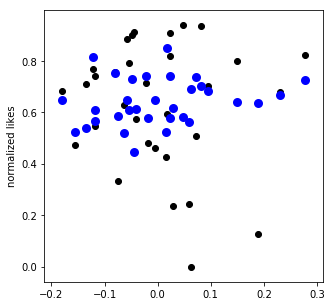

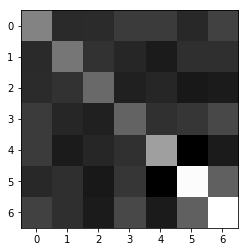

[ 0.0061175   0.00125446 -0.00374842  0.00749657 -0.00387266  0.01366644
  0.0540661 ]


In [11]:
# Extract features

likes = dfp['likes'].apply(lambda x: float(convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1
hour = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[1]).values
weekday = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[0]).values


# Prune and normalize data
    
keep = (likes < 2000) & (likes > 1) #& (ntags < 18)
#keep = dfp.apply(not_in_list,args=[u'fashion',0],axis=1).values & keep

goodposts = dfp.loc[keep]
goodsat = sat[keep]
goodcontrast = contrast[keep]
gcomp = comp[keep]
print goodcontrast.shape

likes = likes[keep]
ntags = ntags[keep]

gCos = kCos[keep]
gSin = kSin[keep]

minsat = np.min(sat)
maxsat = np.max(sat)
mincon = np.min(goodcontrast)
maxcon = np.max(goodcontrast)
minlike = min(likes)
maxlike = max(likes)
mintags = min(ntags)
maxtags = max(ntags)

gSinA = np.abs(gSin)/np.max(np.abs(gSin))

goodsat = (goodsat - minsat)/(maxsat-minsat)
goodcontrast = (goodcontrast - mincon)/(maxcon-mincon)
likes = (likes - minlike)/(maxlike - minlike)
gcomp = gcomp/255.
ntags = (ntags - np.mean(ntags))/(maxtags - mintags)
gCos = (gCos - np.mean(gCos))/(np.max(gCos) - np.min(gCos))
gSin = (gSin - np.mean(gSin))/(np.max(gSin) - np.min(gSin))


# Split into test and training sets

nposts = len(goodposts)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

if False:
    data_train = np.zeros([ntrain,(1+2+4+4+1+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1] = gCos[train]
    data_train[:,2] = gSin[train]
    data_train[:,3:7] = gcomp[train,:4]
    data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,11] = goodcontrast[train]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+2+4+4+1+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1] = gCos[test]
    data_test[:,2] = gSin[test]
    data_test[:,3:7] = gcomp[test,:4]
    data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,11] = goodcontrast[test]
    data_test[:,-1] = ntags[test]

elif True:
    data_train = np.zeros([ntrain,1+2+1+1+1])
    data_train[:,0] = gCos[train]
    data_train[:,1] = gSin[train]
    data_train[:,2] = goodsat[train]
    data_train[:,3] = goodcontrast[train]
    data_train[:,-2] = gSinA[train]
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1+2+1+1+1])
    data_test[:,0] = gCos[test]
    data_test[:,1] = gSin[test]
    data_test[:,2] = goodsat[test]
    data_test[:,3] = goodcontrast[test]
    data_test[:,-2] = gSinA[test]
    data_test[:,-1] = ntags[test]
    
elif False:
    data_train = np.zeros([ntrain,1+1+1])
    data_train[:,0] = gCos[train]
    data_train[:,1] = gSin[train]
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1+1+1])
    data_test[:,0] = gCos[test]
    data_test[:,1] = gSin[test]
    data_test[:,-1] = ntags[test]
    
elif True:
    data_train = np.zeros([ntrain,1])
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1])
    data_test[:,-1] = ntags[test]
    
elif False:
    data_train = np.zeros([ntrain,(1+20+25+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1:21] = goodcontrast[train,:]
    data_train[:,21:46] = gcomp[train]
    #data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+20+25+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1:21] = goodcontrast[test,:]
    data_test[:,21:46] = gcomp[test]
    #data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,-1] = ntags[test]

elif True:
    data_train = np.zeros([ntrain,(25+20+1)])
    data_train[:,0:25] = gcomp[train,:]
    data_train[:,25:-1] = goodcontrast[train]
    data_train[:,-1] = goodsat[train]

    data_test = np.zeros([(nposts-ntrain),(25+20+1)])
    data_test[:,0:25] = gcomp[test,:]
    data_test[:,25:-1] = goodcontrast[test]
    data_test[:,-1] = goodsat[test]

    
y_train = likes[train]
y_test = likes[test]


# Run regression

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)

fig = plt.figure(figsize=[5,5])
feat = 0
plt.scatter(data_test[:,feat], y_test,  color='black')
plt.scatter(data_test[:,feat], y_pred, color='blue', linewidth=3)
#plt.xlabel('normalized contrast')
plt.ylabel('normalized likes')
plt.show()

cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
plt.imshow(cov,cmap='gray')
plt.show()
print cov[-1,:] #, data_test[1,:]


# Results for various users, feature by feature


DEFAULT: (likes < 5000) & (likes > 1)


Using posts from the account iceandvice:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.038600
        R2S: 0.125009

    Feature list (tags, contrast, comp, sat):
        data_train = np.zeros([ntrain,(1+20+25+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1:21] = goodcontrast[train,:]
        data_train[:,21:46] = gcomp[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.036045
        R2S: 0.182930
    
Image features are important! :)



Using posts from the account dinarakasko:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.059200
        R2S: 0.082015

        (ntags < 18)
        MSE: 0.045560
        R2S: -0.006176

    Feature list (tags, contrast, comp, sat):
        data_train = np.zeros([ntrain,(1+20+25+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1:21] = goodcontrast[train,:]
        data_train[:,21:46] = gcomp[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.070896
        R2S: -0.099338

        (ntags < 18)
        MSE: 0.050597
        R2S: -0.117415 

    (contrast, comp, sat):
        data_train = np.zeros([ntrain,(25+20+1)])
        data_train[:,0:25] = gcomp[train,:]
        data_train[:,25:-1] = goodcontrast[train]
        data_train[:,-1] = goodsat[train]

        MSE: 0.073615
        R2S: -0.141510

        (ntags < 18)
        MSE: 0.050807
        R2S: -0.122046

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+4+4+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,3:7] = gcomp[train,:4]
        data_train[:,7:11] = gcomp[train,-4:]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.053433
        R2S: 0.171454



Using posts from the account stuffbeneats:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.022036
        R2S: 0.360145

    Feature list (tags, contrast, comp, sat):
        data_train = np.zeros([ntrain,(1+20+25+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1:21] = goodcontrast[train,:]
        data_train[:,21:46] = gcomp[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.024785
        R2S: 0.280334

    (contrast, comp, sat):
        data_train = np.zeros([ntrain,(25+20+1)])
        data_train[:,0:25] = gcomp[train,:]
        data_train[:,25:-1] = goodcontrast[train]
        data_train[:,-1] = goodsat[train]

        MSE: 0.033790
        R2S: 0.018873

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+4+4+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,3:7] = gcomp[train,:4]
        data_train[:,7:11] = gcomp[train,-4:]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.023213
        R2S: 0.325974

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.021796
        R2S: 0.367120


Using posts from the account hungrygrls:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.010179
        R2S: 0.004093

        (likes < 2000)
        MSE: 0.028576
        R2S: -0.001235


    Feature list (tags, contrast, comp, sat):
        data_train = np.zeros([ntrain,(1+20+25+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1:21] = goodcontrast[train,:]
        data_train[:,21:46] = gcomp[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.010611
        R2S: -0.038145

    (contrast, comp, sat):
        data_train = np.zeros([ntrain,(25+20+1)])
        data_train[:,0:25] = gcomp[train,:]
        data_train[:,25:-1] = goodcontrast[train]
        data_train[:,-1] = goodsat[train]

        MSE: 0.010655
        R2S: -0.042472


    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.010265
        R2S: -0.004352

        (likes < 2000)
        MSE: 0.028395
        R2S: 0.005105


Using posts from the account eightturncrepeny:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.022951
        R2S: 0.006443

    Feature list (tags, contrast, comp, sat):
        data_train = np.zeros([ntrain,(1+20+25+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1:21] = goodcontrast[train,:]
        data_train[:,21:46] = gcomp[train]
        data_train[:,-1] = ntags[train]

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.022597
        R2S: 0.021778

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-2] = gSinA[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.022587
        R2S: 0.022202



Using posts from the account pollykosheleva:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.068855
        R2S: 0.006524

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-2] = gSinA[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.063140
        R2S: 0.088984



Using posts from the account omjsk:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]

        MSE: 0.085625
        R2S: 0.143835

    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-2] = gSinA[train]
        data_train[:,-1] = ntags[train]

        MSE: 0.078891
        R2S: 0.211168

    
   
Using posts from the account ezgipolat:

    Feature list (just tags):
        data_train = np.zeros([ntrain,1])
        data_train[:,-1] = ntags[train]


    (sat,cos,sin,comp,contrast,tags):
        data_train = np.zeros([ntrain,(1+2+1+1)])
        data_train[:,0] = goodsat[train]
        data_train[:,1] = gCos[train]
        data_train[:,2] = gSin[train]
        data_train[:,11] = goodcontrast[train]
        data_train[:,-2] = gSinA[train]
        data_train[:,-1] = ntags[train]



   

## Results using automatic feature selector

No outlier rejection, no output regularizatioon

pollykosheleva:

    [ True False False False  True False False  True  True  True] 2 6

    Cross Validation with best features:
    MSE: 0.001875
    R2S: 0.250890

    Test set with best features:
    MSE: 0.001986
    R2S: 0.177785

    Cross Validation with just metadata:
    MSE: 0.002489
    R2S: 0.005658

    Test set with just metadata:
    MSE: 0.002415
    R2S: 0.000140
    
    
jamesjeanart:

    [False False False  True  True  True  True False  True False] 1 5

    Cross Validation with best features:
    MSE: 0.001825
    R2S: -0.005410

    Test set with best features:
    MSE: 0.001731
    R2S: 0.033569

    Cross Validation with just metadata:
    MSE: 0.001899
    R2S: -0.046262

    Test set with just metadata:
    MSE: 0.001831
    R2S: -0.022264
    
    
taiyakinyc:

    [ True  True False False  True  True  True False False False] 5 8

    Cross Validation with best features:
    MSE: 0.018735
    R2S: 0.103097

    Test set with best features:
    MSE: 0.018363
    R2S: -0.107244

    Cross Validation with just metadata:
    MSE: 0.022171
    R2S: -0.061403

    Test set with just metadata:
    MSE: 0.016766
    R2S: -0.010960
    
    
### auto feature selector with auto outlier rejection

cake.and.sweets.17

    Cross Validation with best features:
    MSE: 0.011732
    R2S: 0.456339

    Test set with best features:
    MSE: 0.012991
    R2S: 0.392773

    Cross Validation with just metadata:
    MSE: 0.021599
    R2S: -0.000880

    Test set with just metadata:
    MSE: 0.021416
    R2S: -0.001079

    Average # likes in test set: 8.538   Average # likes in suggested posts: 12.750
    Average increase in likes:  0.493243243243


cedricgrolet

    Cross Validation with best features:
    MSE: 0.008870
    R2S: 0.115507

    Test set with best features:
    MSE: 0.011906
    R2S: 0.025764

    Cross Validation with just metadata:
    MSE: 0.010151
    R2S: -0.012226

    Test set with just metadata:
    MSE: 0.012277
    R2S: -0.004660

    Average # likes in test set: 11167.700   Average # likes in suggested posts: 13717.625
    Average increase in likes:  0.228330363459


dinarakasko

    [ True  True  True  True False  True False False  True  True False False
     False False False False False False False False False False False False
     False False False False False False False False False False False False
     False False False False False] 2 7

    Cross Validation with best features:
    MSE: 0.002216
    R2S: 0.156310

    Test set with best features:
    MSE: 0.002717
    R2S: 0.228648

    Cross Validation with just metadata:
    MSE: 0.002683
    R2S: -0.021375

    Test set with just metadata:
    MSE: 0.003527
    R2S: -0.001415

    Average # likes in test set: 3015.850   Average # likes in suggested posts: 3066.167
    Average increase in likes:  0.0166840746943
    
    
ezgipolat (not food - art)

    Cross Validation with best features:
    MSE: 0.008287
    R2S: 0.340793

    Test set with best features:
    MSE: 0.009585
    R2S: 0.241050

    Cross Validation with just metadata:
    MSE: 0.012572
    R2S: -0.000020

    Test set with just metadata:
    MSE: 0.012670
    R2S: -0.003305

    Average # likes in test set: 7624.823   Average # likes in suggested posts: 9386.618
    Average increase in likes:  0.231060436441


eightturncrepeny

    Cross Validation with best features:
    MSE: 0.011041
    R2S: -0.019747

    Test set with best features:
    MSE: 0.009792
    R2S: -0.033148

    Cross Validation with just metadata:
    MSE: 0.010830
    R2S: -0.000277

    Test set with just metadata:
    MSE: 0.009493
    R2S: -0.001550

    Average # likes in test set: 90.918   Average # likes in suggested posts: 88.881
    Average increase in likes:  -0.022395790291
    

garrylarduinat

    Cross Validation with best features:
    MSE: 0.008723
    R2S: 0.258342
    Spearman 1.000000

    Test set with best features:
    MSE: 0.010386
    R2S: -0.611726
    Spearman 1.000000

    Cross Validation with just metadata:
    MSE: 0.011803
    R2S: -0.003515

    Test set with just metadata:
    MSE: 0.009031
    R2S: -0.401487

    Average # likes in test set: 5364.964   Average # likes in suggested posts: 5597.333
    Average increase in likes:  0.043312319569
    
    
iamdessertlover

    Cross Validation with best features:
    MSE: 0.001287
    R2S: -0.124202

    Test set with best features:
    MSE: 0.001204
    R2S: -0.028409

    Cross Validation with just metadata:
    MSE: 0.001146
    R2S: -0.001321

    Test set with just metadata:
    MSE: 0.001174
    R2S: -0.002596

    Average # likes in test set: 33.366   Average # likes in suggested posts: 30.839
    Average increase in likes:  -0.0757538049201
    
    
iceandvice

    [ True False False  True False False False  True  True  True False False
     False False False False False False False False False False False False
     False False False  True False False  True  True False False False False
     False False  True False False] 4 9

    Cross Validation with best features:
    MSE: 0.003680
    R2S: 0.202676

    Test set with best features:
    MSE: 0.004065
    R2S: 0.085107

    Cross Validation with just metadata:
    MSE: 0.004542
    R2S: 0.015917

    Test set with just metadata:
    MSE: 0.004436
    R2S: 0.001596
    
    Average # likes in test set: 1046.664   Average # likes in suggested posts: 1576.881
    Average increase in likes:  0.506577660529
    
    
jacquesgenin

    Cross Validation with best features:
    MSE: 0.009850
    R2S: 0.169933
    Spearman: 0.423101

    Test set with best features:
    MSE: 0.011361
    R2S: -0.130393
    Spearman: 0.099198

    Cross Validation with just metadata:
    MSE: 0.012220
    R2S: -0.029729
    Spearman: -0.000000

    Test set with just metadata:
    MSE: 0.010195
    R2S: -0.014344
    Spearman: 0.000000

    Average # likes in test set: 235.412   Average # likes in suggested posts: 284.000
    Average increase in likes:  0.206396801599
    
    
lolly_cakery

    Cross Validation with best features:
    MSE: 0.005647
    R2S: 0.275535

    Test set with best features:
    MSE: 0.005884
    R2S: 0.185552

    Cross Validation with just metadata:
    MSE: 0.007814
    R2S: -0.002524

    Test set with just metadata:
    MSE: 0.007307
    R2S: -0.011314

    Average # likes in test set: 91.714   Average # likes in suggested posts: 117.909
    Average increase in likes:  0.285613140753


pollykosheleva

    [ True False False  True  True False False  True  True  True False False
     False False False False False False False False False False False False
     False False False False False False False False False False False False
     False False False False False] 1 6

    Cross Validation with best features:
    MSE: 0.001376
    R2S: 0.206631

    Test set with best features:
    MSE: 0.001479
    R2S: 0.124334

    Cross Validation with just metadata:
    MSE: 0.001730
    R2S: 0.002746

    Test set with just metadata:
    MSE: 0.001706
    R2S: -0.009909
    
    Average # likes in test set: 1238.566   Average # likes in suggested posts: 1641.060
    Average increase in likes:  0.324968267463
    

stuffbeneats

    Cross Validation with best features:
    MSE: 0.000196
    R2S: 0.486591

    Test set with best features:
    MSE: 0.000210
    R2S: 0.429239

    Cross Validation with just metadata:
    MSE: 0.000379
    R2S: 0.004092

    Test set with just metadata:
    MSE: 0.000362
    R2S: 0.014937

    Average # likes in test set: 1145.488   Average # likes in suggested posts: 1383.520
    Average increase in likes:  0.207799850953


taiyakinyc

    Cross Validation with best features:
    MSE: 0.009289
    R2S: 0.130914

    Test set with best features:
    MSE: 0.009801
    R2S: 0.231657

    Cross Validation with just metadata:
    MSE: 0.010698
    R2S: -0.000907

    Test set with just metadata:
    MSE: 0.013242
    R2S: -0.038166

    Average # likes in test set: 2667.179   Average # likes in suggested posts: 3284.000
    Average increase in likes:  0.231263641355


way_cake

    Cross Validation with best features:
    MSE: 0.009031
    R2S: 0.092410

    Test set with best features:
    MSE: 0.008758
    R2S: 0.086662

    Cross Validation with just metadata:
    MSE: 0.009969
    R2S: -0.001932

    Test set with just metadata:
    MSE: 0.010045
    R2S: -0.047578

    Average # likes in test set: 69.259   Average # likes in suggested posts: 72.000
    Average increase in likes:  0.0395721925134
    

\# cakes

    Cross Validation with best features:
    MSE: 0.000008
    R2S: 0.793926
    Spearman: 0.910998

    Test set with best features:
    MSE: 0.000005
    R2S: 0.841366
    Spearman: 0.917892

    Cross Validation with just metadata:
    MSE: 0.000009
    R2S: 0.753025
    Spearman: 0.888468

    Test set with just metadata:
    MSE: 0.000005
    R2S: 0.842587
    Spearman: 0.924359

    Average # likes in test set: 30.803   Average # likes in suggested posts: 53.000
    Average increase in likes:  0.720609936055
    
    Ver.2
    
    Cross Validation with best features:
    MSE: 0.000008
    R2S: 0.793926
    Spearman: 0.910998

    Test set with best features:
    MSE: 0.000005
    R2S: 0.841366
    Spearman: 0.917892

    Average # likes in test set: 30.803   Average # likes in suggested posts: 53.800
    Average increase in likes: 0.747   Total # samples: 66

    Cross Validation with best features without user data:
    MSE: 0.000038
    R2S: -0.004851
    Spearman: 0.083587

    Test set with best features without user data:
    MSE: 0.000028
    R2S: 0.057339
    Spearman: 0.240945

    Average # likes in test set: 30.803   Average # likes in suggested posts: 32.650
    Average increase in likes: 0.060   Total # samples: 66

    Cross Validation with just user data:
    MSE: 0.000008
    R2S: 0.783637
    Spearman: 0.907172

    Test set with just data:
    MSE: 0.000004
    R2S: 0.850467
    Spearman: 0.924371

    Average # likes in test set: 30.803   Average # likes in suggested posts: 53.800
    Average increase in likes: 0.747   Total # samples: 66
    
    
\# cake

    Cross Validation with best features:
    MSE: 0.000000
    R2S: 0.758907
    Spearman: 0.871738

    Test set with best features:
    MSE: 0.000000
    R2S: 0.828566
    Spearman: 0.919591

    Average # likes in test set: 34.920   Average # likes in suggested posts: 62.429
    Average increase in likes: 0.788   Total # samples: 162

    Cross Validation with best features without user data:
    MSE: 0.000002
    R2S: 0.037216
    Spearman: 0.229664

    Test set with best features without user data:
    MSE: 0.000003
    R2S: 0.052691
    Spearman: 0.232072

    Average # likes in test set: 34.920   Average # likes in suggested posts: 44.245
    Average increase in likes: 0.267   Total # samples: 162

    Cross Validation with just user data:
    MSE: 0.000001
    R2S: 0.743889
    Spearman: 0.862998

    Test set with just data:
    MSE: 0.000000
    R2S: 0.824960
    Spearman: 0.917693

    Average # likes in test set: 34.920   Average # likes in suggested posts: 62.041
    Average increase in likes: 0.777   Total # samples: 162


    
### With nlikes regularization

\#icecream

    [False False False False False False False  True False  True False False
     False False False False False False False False False False False False
     False False False False False False False False False False False False
     False False False False False  True  True] 2 4

    Cross Validation with best features:
    MSE: 0.000001
    R2S: 0.261725

    Test set with best features:
    MSE: 0.000002
    R2S: 0.118189

    Cross Validation with just metadata:
    MSE: 0.000001
    R2S: 0.020338

    Test set with just metadata:
    MSE: 0.000002
    R2S: 0.017114
    
    
### With mean nlikes

\#cake

    [False  True False  True False  True False False False  True False False
     False False False False False False False False False False False False
     False False False False False False False False False False False False
     False False False False False False False  True False  True] 1 6

    Cross Validation with best features:
    MSE: 0.000000
    R2S: 0.758907

    Test set with best features:
    MSE: 0.000000
    R2S: 0.828566

    Cross Validation with just metadata:
    MSE: 0.000001
    R2S: 0.733601

    Test set with just metadata:
    MSE: 0.000000
    R2S: 0.821699
    
    Average # likes in test set: 34.920   Average # likes in suggested posts: 62.694
    Average increase in likes:  0.795370012951
    

\#cakes

    [ True  True  True False  True False  True  True  True  True False False
     False False False False False False False False False False False False
     False False False False False False False False False False False False
     False False False False False  True False  True False  True] 1 11

    Cross Validation with best features:
    MSE: 0.000008
    R2S: 0.793926

    Test set with best features:
    MSE: 0.000005
    R2S: 0.841366

    Cross Validation with just metadata:
    MSE: 0.000009
    R2S: 0.753025

    Test set with just metadata:
    MSE: 0.000005
    R2S: 0.842587
    
    Average # likes in test set: 30.803   Average # likes in suggested posts: 53.000
    Average increase in likes:  0.720609936055
    
    
